# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

## 1.Завантаження залежних та незалежних вибірок з текстових файлів. 

         x         y
0  21.5447  134.3021
1  18.1367  130.5072
2  13.3060  132.6800
3  -2.4954  131.8808
4  20.9216  133.8112


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

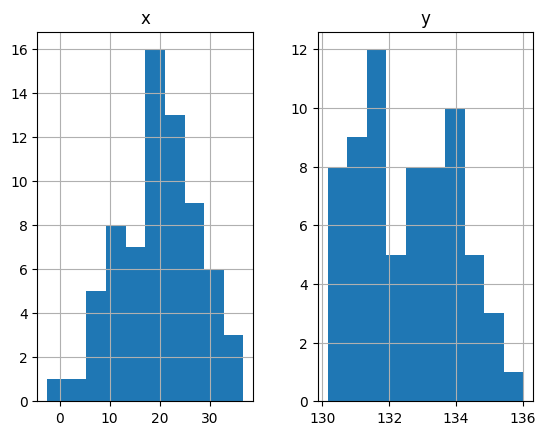

In [2]:
path = "../data_lab4/dep/nr.txt"
columns = ['x','y']
df = pd.read_csv(path, delimiter=" ", header=None, names=columns)
word_to_check = "indep"
normal:bool=None
if word_to_check in path:
    x_values = df[df['y'] == 0]['x'].reset_index(drop=True)
    y_values = df[df['y'] == 1]['x'].reset_index(drop=True)
    # Create a new DataFrame with 'x' and 'y' columns
    df = pd.DataFrame({'x': x_values, 'y': y_values})
    independent = True
else:
    independent = False    
print(df.head())
df.hist()

## Creating class for calculation quantiles

In [3]:
# Коефіцієнти для формули
C0 = 2.515_517
C1 = 0.802_853
C2 = 0.010_328
D1 = 1.432_788
D2 = 0.189_265_9
D3 = 0.001_308

class Quantile:
    
    @classmethod
    def calculate_quantile(cls, p):
        if p > 0.5:
            t = np.sqrt(-2 * np.log(1 - p))
            quantile = (t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))
        else:
            t = np.sqrt(-2 * np.log(p))
            quantile = -(t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))

        return quantile
        
    @staticmethod
    def student_quantile(p, v):
        up = Quantile.calculate_quantile(p)
        tpv = up + (1 / v) * (1 / 4) * (up ** 3 + up) + (1 / v ** 2) * (1 / 96) * (
            5 * up ** 5 + 16 * up ** 3 + 3 * up) + (1 / v ** 3) * (1 / 384) * (
                  3 * up ** 7 + 19 * up ** 5 + 17 * up ** 3 - 15 * up) + (1 / v ** 4) * (1 / 92_160) * (
                  79 * up ** 9 + 779 * up ** 7 + 1_482 * up ** 5 - 1_920 * up ** 3 - 945 * up)
        return tpv
    
    @staticmethod
    def fisher_quantile(p ,v1, v2):
        up = Quantile.calculate_quantile(p)   

        sigma = 1/v1 + 1/v2
        delta = 1/v1 - 1/v2
        
        z = (up * np.sqrt(sigma / 2) -
         (1 / 6) * delta * (up**2 + 2) +
         np.sqrt(sigma / 2) * (sigma / 24 * (up**2 + 3 * up) + (1 / 72) * (delta**2 / sigma) * (up**3 + 11 * up)) -
         (sigma * delta / 120) * (up**4 + 9 * up**2 + 8) +
         (delta**3 / (3240 * sigma)) * (3 * up**4 + 7 * up**2 - 16) +
         np.sqrt(sigma / 2) * (sigma**2 / 1920 * (up**5 + 20 * up**3 + 15 * up)) +
         (delta**4 / 2880) * (up**5 + 44 * up**3 + 183 * up) +
         (delta**5 / (155520 * sigma**2)) * (9 * up**5 + 284 * up**3 + 1513 * up)
        )

        return np.exp(2*z)

## Критерії перевірки однорідності двох залежних вибірок: критерії перевірки рівності дисперсій та середніх + критерій знакових рангів Вілкоксона

In [4]:
class DependentSamples:
    @classmethod
    def create_thrird_sample(cls, df):
        df['z'] = df['x']-df['y']

        z_mean = np.mean(df['z'])
        z_std = np.std(df['z'], ddof=1)
       
        return DependentSamples.calculate_t(len(df)-1, z_mean, z_std)
    
    @classmethod
    def calculate_t(cls, length, z_mean, z_std):
        if z_mean==0 and z_std==0:
            t=0
        else:
            t = z_mean*np.sqrt(length)/z_std
        return DependentSamples.is_mean_equal(t, length-1)

    @classmethod
    def is_mean_equal(cls, t, n):
        print('t equals: '+str(t))
        print('Quantile: '+str(Quantile.student_quantile(1-0.05/2, n)))
        return np.abs(t)<=Quantile.student_quantile(1-0.05/2, n)

    # @classmethod
    # def is_variances_equal(cls, t, n):
    #     print('t equals: '+str(t))
    #     print('Quantile: '+str(Quantile.student_quantile(1-0.05/2, n)))
    #     return np.abs(t)<=Quantile.student_quantile(1-0.05/2, n)
    
    @classmethod
    def calculate_statistic(cls, df):
        squared_x_std = np.std(df['x'], ddof=1)**2
        squared_y_std = np.std(df['y'], ddof=1)**2
        if(squared_x_std>=squared_y_std):
            f=squared_x_std/squared_y_std
            v1 = df['x'].count() - 1
            v2 = df['y'].count() - 1 
        else:
            f=squared_y_std/squared_x_std
            v1 = df['y'].count() - 1 
            v2 = df['x'].count() - 1
        
        #check is variances coincide
        f_fisher = Quantile.fisher_quantile(0.95,v1,v2)
        print('F:' +str(f))
        print('F fisher:' +str(f_fisher))
        return f<=f_fisher

    @classmethod
    def create_sample_signs_ranks(cls, df):
        df['z'] = df['x']-df['y']

        df['s'] = [1 if z > 0 else 0 if z < 0 else None for z in df['z']]
        df.dropna()
        df['|z|'] = [np.abs(x) for x in df['z']]
        df['r'] = df['|z|'].rank()
        df['s*r'] = df['r']*df['s']
        t = sum( df['s*r'])
        return t
        
    @classmethod
    def calculate_standardized_statistics_u(cls, n, t):
        et=1/4*n*(n+1)
        dt=1/24*n*(n+1)*(2*n+1)
        return (t-et)/(np.sqrt(dt))
        

    @classmethod
    def is_functions_shifted(cls, u):
        return np.abs(u)>Quantile.calculate_quantile(1-0.05/2)
        
    @staticmethod
    def check_for_homogeneity(df):
        mean_equal = DependentSamples.create_thrird_sample(df)
        varians_equal = DependentSamples.calculate_statistic(df)
        print('Is mean equals: '+str(mean_equal))
        print('Is varians equals: '+str(varians_equal))

    @staticmethod
    def check_for_homogeneity(df):
        mean_equal = DependentSamples.create_thrird_sample(df)
        varians_equal = DependentSamples.calculate_statistic(df)
        print('Is mean equals: '+str(mean_equal))
        print('Is varians equals: '+str(varians_equal))
        if mean_equal and varians_equal:
            print('homogeneous sample')
        else:
            print('NOT homogeneous sample')

    @staticmethod
    def calculate_rank_with_wilcoxon(df):
        res = DependentSamples.create_sample_signs_ranks(df)
            
        return res

#### Test

In [5]:
DependentSamples.check_for_homogeneity(df)
t = DependentSamples.calculate_rank_with_wilcoxon(df)
u = DependentSamples.calculate_standardized_statistics_u(df['x'].count(),t)
print('u equals: '+str(u))
print('quantile equals: '+str(Quantile.calculate_quantile(1-0.05/2)))
print('is sfit present: '+str(DependentSamples.is_functions_shifted(u)))


t equals: -108.7788197796626
Quantile: 1.996457126547252
F:29.825274128333508
F fisher:1.493775767083493
Is mean equals: False
Is varians equals: False
NOT homogeneous sample
u equals: -7.219577699441525
quantile equals: 1.960392179315197
is sfit present: True


## Критерії перевірки однорідності двох незалежних вибірок: критерії перевірки рівності дисперсій та середніх + ранговий критерій, заданий індивідуальним варіантом.

In [6]:
class IndependentSamples:
    @classmethod
    def calculate_weighted_average_and_t(cls, df):
        x_mean = np.mean(df['x'])
        y_mean = np.mean(df['y'])
        x_dispersion = np.std(df['x'], ddof=1)**2
        y_dispersion = np.std(df['y'], ddof=1)**2
        x_n =df['x'].count()
        y_n =df['y'].count()

        weighted_average = ((x_n-1)*x_dispersion+(y_n-1)*y_dispersion)/(x_n+y_n-2)
        
        t = (x_mean-y_mean)/(np.sqrt(weighted_average/x_n+weighted_average/y_n))
        
        print('weighted average: '+str(weighted_average))
        print('t equals: '+str(t))
        
        return IndependentSamples.is_mean_equal(t, x_n+y_n-2)

    @classmethod
    def is_mean_equal(cls, t, v):
        print('Quantile: '+str(Quantile.student_quantile(1-0.05/2, v)))
        return np.abs(t)<=Quantile.student_quantile(1-0.05/2, v)

    @classmethod
    def calculate_criterion_with_welch_correction(cls, df):
        x_mean = np.mean(df['x'])
        y_mean = np.mean(df['y'])
        x_dispersion = np.std(df['x'], ddof=1)**2
        y_dispersion = np.std(df['y'], ddof=1)**2
        x_n =df['x'].count()
        y_n =df['y'].count()
        
        t = (x_mean-y_mean)/(np.sqrt(x_dispersion/x_n+y_dispersion/y_n))
        
        v = (x_dispersion/x_n+y_dispersion/y_n)**2*((1/(x_n-1)*(x_dispersion/x_n)**2)+(1/(y_n-1)*(y_dispersion/y_n)**2))**-1

        print('v: '+str(v))
        print('t equals: '+str(t))
        
        return IndependentSamples.is_mean_equal(t, v)

    @classmethod
    def claculate_rank_shift_criterion(cls, df, n1, n2):
        v = sum(list(df))
        ev = 1/2*n1*n2
        dv = 1/12*n1*n2*(n1+n2+1)
        u = (v-ev)/np.sqrt(dv)
        print('v equals: '+str(v))
        print('E{V} equals: '+str(ev))
        print('D{V} equals: '+str(dv))
        print('u equals: '+str(u))
        quantile = Quantile.calculate_quantile(1-0.05/2)
        print('Quantile: '+str(quantile))
        return np.abs(u)<=quantile
    
    @staticmethod
    def check_for_homogeneity(df, varians_equal):

        if varians_equal:
            mean_equal = IndependentSamples.calculate_weighted_average_and_t(df)
        else:
            mean_equal = IndependentSamples.calculate_criterion_with_welch_correction(df)

        print('Is mean equals: '+str(mean_equal))
        print('Is varians equals: '+str(varians_equal))
        if mean_equal and varians_equal:
            print('homogeneous sample')
        else:
            print('NOT homogeneous sample')
       

    @staticmethod
    def calculate_rank_with_mann_whitney(df):
        result = {}
        for x_val in df['x']:
            inversions = 0
            for y_val in df['y']:
                if y_val < x_val:
                    inversions += 1
                elif y_val == x_val:
                    inversions += 0.5  # semi inversion
            result[x_val] = inversions
        shift_exist = IndependentSamples.claculate_rank_shift_criterion(result.values(), df['x'].count(), df['y'].count())
        if shift_exist:
            print('NO shift exist')
        else:
            print('shift exist')
            
        return shift_exist

#### Test

In [7]:
print(''+str(IndependentSamples.check_for_homogeneity(df, DependentSamples.calculate_statistic(df))))
res = IndependentSamples.calculate_rank_with_mann_whitney(df)

F:29.825274128333508
F fisher:1.493775767083493
v: 72.55477070495581
t equals: -115.99311528730358
Quantile: 1.993650341594479
Is mean equals: False
Is varians equals: False
NOT homogeneous sample
None
v equals: 0
E{V} equals: 2380.5
D{V} equals: 55148.25
u equals: -10.13683361229991
Quantile: 1.960392179315197
shift exist


### Check wheather distribution normal or not

In [8]:
def distribution_normal(df):
    alpha = 0.05
    
    # Shapiro-Wilk test for 'x'
    statistic_x, p_value_x = stats.shapiro(df[df.columns[0]])
    normal_x = p_value_x > alpha
    print(p_value_x)
    
    # Shapiro-Wilk test for 'y'
    statistic_y, p_value_y = stats.shapiro(df[df.columns[1]])
    normal_y = p_value_y > alpha
    print(p_value_y)
    # Checking normality for both 'x' and 'y'
    print('Whether first sample normal: ' + str(normal_x))
    print('Whether second sample normal: ' + str(normal_y) + '\n')
    if normal_x and normal_y:
        normal = True
    else:
        normal = False
    
    return normal

distribution_normal(df)

0.6841051578521729
0.022206487134099007
Whether first sample normal: True
Whether second sample normal: False



False

## Підрахунок і виведення у таблицю незсунених кількісних характеристики кожної виибірки, а також вибірки різниць у випадку залежних вибірок. 

### creating class for calculating a Quantitative Characteristics

In [9]:
class QuantitativeCharacteristics:

    def __init__(self,sample):
        self.sample = sample
        self.characteristic_fields_map = ["Mean", "Median", "Std", "Skewness", "Kurtosis", "Min", "Max"]
        self.characteristic_table_dictionary = dict()
        self.mean = None
        self.std_deviation = None
        self.a = None
        self.e = None
        self.sa = None
        self.se = None
    
    def add_to_dictionary(self, column_name, column_data):
        self.characteristic_table_dictionary.update({column_name: column_data})

    def display(self):
        self.add_characteristics()
        return self.characteristic_table_dictionary

    def add_characteristics(self):
        estimation = self.calculate_estimation()
        self.add_to_dictionary("Characteristic", self.characteristic_fields_map)
        self.add_to_dictionary("Estimation", estimation.keys())
        self.add_to_dictionary("SEM", estimation.values())
        confidence_intervals = self.calculate_confidence_interval(estimation)
        self.add_to_dictionary("95% Confidence Interval", confidence_intervals)

    def calculate_confidence_interval(self, estimation: dict):
        confidence_interval = list(range(0, 7))
        median_conf_interval = self.calculate_median_confidence_interval(list(estimation.keys())[1])
        confidence_interval[1] = f"[{median_conf_interval[0]}; {median_conf_interval[1]}]"
        confidence_interval[5] = "───"
        confidence_interval[6] = "───"

        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(0.95, v)
        print("student_quantile: " + str(student_quantile))
        i = 0
        for key in estimation.keys():
            if (estimation.get(key) == "───"):
                i = i + 1
                continue
            upper_bound = round(key - student_quantile * estimation.get(key), 4)
            lower_bound = round(key + student_quantile * estimation.get(key), 4)
            confidence_interval[i] = f"[{upper_bound}; {lower_bound}]"

            i = i + 1

        return confidence_interval

    def calculate_median_confidence_interval(self, median):
        num_samples = 1000

        bootstrap_samples = [np.random.choice(self.sample, size=len(self.sample), replace=True) for _ in
                             range(num_samples)]

        bootstrap_medians = np.median(bootstrap_samples, axis=1)

        std_error_median = np.std(bootstrap_medians, ddof=1)
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(median - student_quantile * std_error_median, 4)
        upper_bound = round(median + student_quantile * std_error_median, 4)

        return lower_bound, upper_bound

    def calculate_normal_interval(self):
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(self.mean - student_quantile * self.std_deviation, 4)
        upper_bound = round(self.mean + student_quantile * self.std_deviation, 4)
        return lower_bound, upper_bound

    def calculate_estimation(self):
        estimation_map = dict()
        self.mean = round(np.mean(self.sample), 4)
        median = round(np.median(self.sample), 4)
        self.std_deviation = round(np.std(self.sample, ddof=1), 4)
        self.a = round(stats.skew(self.sample), 4)
        self.e = round(stats.kurtosis(self.sample), 4)
        minimum = round(min(self.sample), 4)
        maximum = round(max(self.sample), 4)

        n_len = len(self.sample)
        mean_std = round(self.std_deviation / np.sqrt(n_len), 4)
        std_std_deviation = round(self.std_deviation / np.sqrt(2 * n_len), 4)
        self.sa = round(np.sqrt(6 * n_len * (n_len - 1) / ((n_len - 2) * (n_len + 1) * (n_len + 3))), 4)
        self.se = round(
            np.sqrt(24 * n_len * (n_len - 1) ** 2 / ((n_len - 3) * (n_len - 2) * (n_len + 3) * (n_len + 5))), 4)

        estimation_map[self.mean] = mean_std
        estimation_map[median] = "───"
        estimation_map[self.std_deviation] = std_std_deviation
        estimation_map[self.a] = self.sa
        estimation_map[self.e] = self.se
        estimation_map[minimum] = "───"
        estimation_map[maximum] = "───"
        return estimation_map

#### Test

In [10]:
q_c1 = QuantitativeCharacteristics(df['x'])
q_c2 = QuantitativeCharacteristics(df['y'])
res1= pd.DataFrame(q_c1.display())
print(res1)
print('----------')
res2=  pd.DataFrame(q_c2.display())
print(res2)


student_quantile: 1.6679396238119202
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     19.9444   0.955      [18.3515; 21.5373]
1         Median     20.4021     ───       [18.9262; 21.878]
2            Std      7.9328  0.6753        [6.8064; 9.0592]
3       Skewness     -0.2139  0.2887       [-0.6954; 0.2676]
4       Kurtosis      0.1835  0.5701       [-0.7674; 1.1344]
5            Min     -2.4954     ───                     ───
6            Max     36.7238     ───                     ───
----------
student_quantile: 1.6679396238119202
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean    132.5588  0.1749    [132.2671; 132.8505]
1         Median    132.6599     ───    [131.9047; 133.4151]
2            Std      1.4526  0.1237        [1.2463; 1.6589]
3       Skewness      0.1563  0.2887       [-0.3252; 0.6378]
4       Kurtosis     -1.0513  0.5701      [-2.0022; -0.1004]
5            Min    130.1601     ───                     ───


#### Calculate P value with CDF(using student quantile)

### Calculate paired t-test

In [11]:
def homogeneity_check(df):
    if(independent):
        if(normal):
            print('Independent, Normal')
            print(str(IndependentSamples.check_for_homogeneity(df, DependentSamples.calculate_statistic(df))))
            
            q_c1 = QuantitativeCharacteristics(df['x'].dropna())
            q_c2 = QuantitativeCharacteristics(df['y'].dropna())
            res1= pd.DataFrame(q_c1.display())
            print(res1)
            print('----------')
            res2=  pd.DataFrame(q_c2.display())
            print(res2) 
        else:
            print('Independent, NOT Normal')
            res = IndependentSamples.calculate_rank_with_mann_whitney(df)
            print(res)
            
            q_c1 = QuantitativeCharacteristics(df['x'].dropna())
            q_c2 = QuantitativeCharacteristics(df['y'].dropna())
            res1= pd.DataFrame(q_c1.display())
            print(res1)
            print('----------')
            res2=  pd.DataFrame(q_c2.display())
            print(res2)     
            
    else:      
        if(normal):
            print('Dependent, Normal')
            DependentSamples.check_for_homogeneity(df)
            q_c1 = QuantitativeCharacteristics(df['x'].dropna())
            q_c2 = QuantitativeCharacteristics(df['y'].dropna())
            res1= pd.DataFrame(q_c1.display())
            print(res1)
            print('----------')
            res2=  pd.DataFrame(q_c2.display())
            print(res2) 
        else:
            print('Dependent, NOT Normal') 
            t = DependentSamples.calculate_rank_with_wilcoxon(df)
            u = DependentSamples.calculate_standardized_statistics_u(df['x'].count(),t)
            print('u equals: '+str(u))
            print('quantile equals: '+str(Quantile.calculate_quantile(1-0.05/2)))
            print('is sfit present: '+str(DependentSamples.is_functions_shifted(u)))

            q_c1 = QuantitativeCharacteristics(df['x'].dropna())
            q_c2 = QuantitativeCharacteristics(df['y'].dropna())
            res1= pd.DataFrame(q_c1.display())
            print(res1)
            print('----------')
            res2=  pd.DataFrame(q_c2.display())
            print(res2) 

### Задача 1. У файлі readingspeed.txt міститься інформація щодо швидкості читання у дітей залежно від методики, за якою їх навчали (DRA – direct reading activities, SC – standart curriculum). Потрібно перевірити, чи різниться швидкість читання у разі навчання за цими методиками . 

In [12]:
path = "../data_lab4_tasks/readingspeed.txt"
df = pd.read_csv(path, delim_whitespace=True)
# Initialize lists for 'DRA' and 'SC' scores
dra_scores = []
sc_scores = []

# Extract 'DRA' and 'SC' scores from the DataFrame
for index, row in df.iterrows():
    if row['LearningType'] == 'DRA':
        dra_scores.append(row['Score'])
    elif row['LearningType'] == 'SC':
        sc_scores.append(row['Score'])

# Adjust lengths of lists to be the same
max_len = max(len(dra_scores), len(sc_scores))
dra_scores.extend([None] * (max_len - len(dra_scores)))
sc_scores.extend([None] * (max_len - len(sc_scores)))

# Create a DataFrame with 'DRA' and 'SC' columns
read_speed_df = pd.DataFrame({'x': dra_scores, 'y': sc_scores})

read_speed_df.head()

,x,y
0,24.0,42
1,43.0,43
2,58.0,55
3,71.0,26
4,43.0,62


In [13]:
normal = distribution_normal(read_speed_df)
independent = True
homogeneity_check(read_speed_df);

1.0
0.7322295904159546
Whether first sample normal: True
Whether second sample normal: True

Independent, Normal
F:2.4271577106788973
F fisher:2.0955857334606
v: 37.85540065943909
t equals: 2.310889197854228
Quantile: 2.0251135360136323
Is mean equals: False
Is varians equals: False
NOT homogeneous sample
None
student_quantile: 1.7251169181872237
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     51.4762   2.402      [47.3325; 55.6199]
1         Median     53.0000     ───        [46.293; 59.707]
2            Std     11.0074  1.6985       [8.0773; 13.9375]
3       Skewness     -0.5810  0.5012       [-1.4456; 0.2836]
4       Kurtosis      0.3519  0.9719       [-1.3247; 2.0285]
5            Min     24.0000     ───                     ───
6            Max     71.0000     ───                     ───
----------
student_quantile: 1.717538847657201
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     41.5217  3.5758      [35.3801; 47.

#### 1. Визначити, залежні чи незалежні вибірки задано у задачі. 

Дві вибірки розглядають різні методики читання тому можна з певністю стверджувати що вони незалежні

#### Перевірити, чи нормально розподілені дані кожної вибірки

Як можна побачити з данних і перша і друга вибірки нормально розподілені. и

#### Для кожної вибірки проаналізувати середнє та 95% довірчий інтервал для нього якщо хоча б одна з вибірок розподілена не за нормальним законом, то поряд із середнім проаналізувати медіану та 95% довірчий інтервал для неї

Щодо швидкості читання у дітей залежно від методики, за якою їх навчали, для першої вибірки видно що середне дорівнює 51.4762 та довірчий інтервал у діапзоні [47.3325; 55.6199].
Для другої  вибірки видно що середне дорівнює 41.5217 та довірчий інтервал у діапзоні [35.3801; 47.6633].
Отже можна побачити що методика DRA кращя за SC

### Задача 2. Для 61 великого міста Англії та Уельсу відома середня річна смертність на 100 тис. населення (за даними 1958-1964 років), а також концентрація калію у воді (в частинах на мільйон). Чим вища концентрація калію, тим жорсткіша вода. Додатково міста поділено на південні та північні. Дані містяться у файлі water.txt. Потрібно перевірити: 1) чи різниться середня смертність на півночі та півдні країни, 2) чи різниться жорсткість води у північних та південнихн містах. 

In [14]:
path = "../data_lab4_tasks/water.txt"
df = pd.read_csv(path, delim_whitespace=True)
water_df = df[[df.columns[0],df.columns[2]]]

north_scores = []
south_scores = []

# Extract 'North' and 'South' mortality from the DataFrame
for index, row in df.iterrows():
    if row['location'] == 'North':
        north_scores.append(row['mortality'])
    elif row['location'] == 'South':
        south_scores.append(row['mortality'])

# Adjust lengths of lists to be the same
max_len = max(len(north_scores), len(south_scores))
north_scores.extend([None] * (max_len - len(north_scores)))
south_scores.extend([None] * (max_len - len(south_scores)))

# Create a DataFrame with North' and 'South' columns
water_df = pd.DataFrame({'x': north_scores, 'y': south_scores})

water_df.head()

,x,y
0,1668,1247.0
1,1800,1466.0
2,1609,1299.0
3,1558,1359.0
4,1807,1392.0


In [15]:
normal = distribution_normal(water_df)
independent = True
homogeneity_check(water_df);

0.6116997599601746
1.0
Whether first sample normal: True
Whether second sample normal: True

Independent, Normal
F:1.0492607615360297
F fisher:1.8302131810857287
weighted average: 19143.126075619293
t equals: 7.168550664340208
Quantile: 2.0014470290861976
Is mean equals: False
Is varians equals: True
NOT homogeneous sample
None
student_quantile: 1.6913042859019731
  Characteristic  Estimation      SEM 95% Confidence Interval
0           Mean   1633.6000  23.1466  [1594.4521; 1672.7479]
1         Median   1637.0000      ───  [1559.4754; 1714.5246]
2            Std    136.9369  16.3671    [109.2552; 164.6186]
3       Skewness      0.0652   0.3977       [-0.6074; 0.7378]
4       Kurtosis     -0.0706   0.7778       [-1.3861; 1.2449]
5            Min   1378.0000      ───                     ───
6            Max   1987.0000      ───                     ───
----------
student_quantile: 1.7085302549378196
  Characteristic  Estimation      SEM 95% Confidence Interval
0           Mean   1376.807

#### 1. Визначити, залежні чи незалежні вибірки задано у задачі. 

Дві вибірки розглядають різні місця з яких береться вода тому можна стверджувати що вони незалежні

#### Перевірити, чи нормально розподілені дані кожної вибірки

Як можна побачити з данних і перша і друга вибірки нормально розподілені. 

#### Для кожної вибірки проаналізувати середнє та 95% довірчий інтервал для нього якщо хоча б одна з вибірок розподілена не за нормальним законом, то поряд із середнім проаналізувати медіану та 95% довірчий інтервал для неї

Щодо смертності на півночі та півдні країни, для першої вибірки видно що середне дорівнює 1633.6000   та довірчий інтервал у діапзоні [1594.4521; 1672.7479].
Для другої  вибірки видно що середне дорівнює 1376.8077 та довірчий інтервал у діапзоні [1329.8076; 1423.8078].
Отже можна побачити що смертностність різниця і вона більше на півночі

### Пунукт 2

In [16]:
water_df = df[[df.columns[0],df.columns[3]]]
north_scores = []
south_scores = []

# Extract 'North' and 'South' mortality from the DataFrame
for index, row in df.iterrows():
    if row['location'] == 'North':
        north_scores.append(row['hardness'])
    elif row['location'] == 'South':
        south_scores.append(row['hardness'])

# Adjust lengths of lists to be the same
max_len = max(len(north_scores), len(south_scores))
north_scores.extend([None] * (max_len - len(north_scores)))
south_scores.extend([None] * (max_len - len(south_scores)))

# Create a DataFrame with North' and 'South' columns
water_hardness_df = pd.DataFrame({'x': north_scores, 'y': south_scores})

water_hardness_df.head()

,x,y
0,17,105.0
1,14,5.0
2,18,78.0
3,10,84.0
4,15,73.0


In [17]:
normal=distribution_normal(water_hardness_df)
independent = True
homogeneity_check(water_hardness_df);

3.4388271160423756e-05
1.0
Whether first sample normal: False
Whether second sample normal: True

Independent, NOT Normal
v equals: 139.0
E{V} equals: 455.0
D{V} equals: 4701.666666666666
u equals: -4.6085166908712605
Quantile: 1.960392179315197
shift exist
False
student_quantile: 1.6913042859019731
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     30.4000  4.4175      [22.9287; 37.8713]
1         Median     17.0000     ───       [8.0638; 25.9362]
2            Std     26.1345  3.1237      [20.8514; 31.4176]
3       Skewness      1.1106  0.3977         [0.438; 1.7832]
4       Kurtosis     -0.0518  0.7778       [-1.3673; 1.2637]
5            Min      6.0000     ───                     ───
6            Max     94.0000     ───                     ───
----------
student_quantile: 1.7085302549378196
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     69.7692  7.9154      [56.2455; 83.2929]
1         Median     75.5000     ───     

#### 1. Визначити, залежні чи незалежні вибірки задано у задачі. 

Зновуж дві вибірки розглядають різні місця з яких береться вода тому можна стверджувати що вони незалежні

#### Перевірити, чи нормально розподілені дані кожної вибірки

Як можна побачити з за тестом Шапіро-Уілка і перша вибірки розподілена НЕ нормально, а друга розподілена нормально. Було застосовано ранговий критерій Манна–Уїтні завдяки йому ми бачемо, що вибірки мають здвиг

#### Для кожної вибірки проаналізувати середнє та 95% довірчий інтервал для нього якщо хоча б одна з вибірок розподілена не за нормальним законом, то поряд із середнім проаналізувати медіану та 95% довірчий інтервал для неї

Щодо жорсткості води у північних та південних містах, для першої вибірки видно що середне дорівнює 30.4000 та довірчий інтервал у діапзоні [22.9287; 37.8713].
Для другої  вибірки видно що середне дорівнює 69.7692 та довірчий інтервал у діапзоні [56.2455; 83.2929].
На підставі цих данних можна стверджувати, що побачити жорсткість води у південих містах набагато більша.
Як висновок після детельного аналізу можна побачити що жорсткість води не впливає на смертність, а навіть якщо і впливає то її вплив дуже малий 

### Задача 3. У рамках дослідження ефективності препарату «метилфенидат» 24 пацієнти із синдромом дефіциту уваги та гіперактивності протягом тижня приймали або метилфенидат, або плацебо. Наприкінці тижня кожен пацієнт проходив тест на здатність до пригнічення імпульсивних поведінкових реакцій. На другому етапі плацебо та препарат мінялися, і після тижневого курсу кожний піддослідний проходив другий тест. Результати першого та другого тестів містяться у файлі ADHD.txt. Потрібно оцінити ефект від застосування препарату. 

In [18]:
path = "../data_lab4_tasks/ADHD.txt"
difference_sampling = pd.read_csv(path, delim_whitespace=True, header=None, skiprows=1, names=['x','y'])

difference_sampling.head()

,x,y
0,57,62
1,27,49
2,32,30
3,31,34
4,34,38


In [19]:
independent = False
homogeneity_check(difference_sampling);
print('------START------')
investigation_df = pd.DataFrame({'x': difference_sampling['z'], 'y': difference_sampling['z']})
normal = distribution_normal(investigation_df)
independent = False
homogeneity_check(investigation_df)
print('------Second homogeneity check------')
homogeneity_check(difference_sampling);

Dependent, NOT Normal
u equals: -2.9
quantile equals: 1.960392179315197
is sfit present: True
student_quantile: 1.714264188783287
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     39.7500  2.3096      [35.7907; 43.7093]
1         Median     36.0000     ───      [31.9236; 40.0764]
2            Std     11.3147  1.6331       [8.5151; 14.1143]
3       Skewness      1.1504  0.4723          [0.3408; 1.96]
4       Kurtosis      0.5605  0.9178       [-1.0129; 2.1339]
5            Min     26.0000     ───                     ───
6            Max     71.0000     ───                     ───
----------
student_quantile: 1.714264188783287
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     44.7083  2.5148      [40.3973; 49.0193]
1         Median     42.5000     ───      [34.4678; 50.5322]
2            Std     12.3199  1.7782       [9.2716; 15.3682]
3       Skewness      0.8199  0.4723        [0.0103; 1.6295]
4       Kurtosis     -0.0012  

#### 1. Сформувати вибірку різниць. 

#### перевірити, чи нормально розподілені ці різниці

За тестом Шапіро-Уілка можна побачити, що вибірка різниць розподілена пормально.

#### Проаналізувати середнє значення різниць разом з 95% довірчим інтервалом; якщо вибірка різниць розподілена не за нормальним законом, то додатково проаналізувати медіану різниць з 95% довірчим інтервалом

Як можна побачити середне значення дорівнює -4.9583 а 95% довірчий інтервал у діапазоні [-7.596; -2.3206], а це може свідчити що значення у другій вибірці є вищі ніж у першій


#### Застосувати для розв’язання задачі параметричний або ранговий критерій в залежності від результатів перевірки на нормальність.

Як бачимо ефект від застосування препарату, для вибірки застосування плацеби видно що середне дорівнює 39.7500 та довірчий інтервал у діапзоні [35.7907; 43.7093]. Для вибірки застосування плацеби видно що середне дорівнює  44.7083  та довірчий інтервал у діапзоні [40.3973; 49.0193].
Отже видно що середні сутьтево різняться і можна зробити висновок що препарат Methylphenidate допоміг більшій кількості паціентів в середньому ніж Плацебо.

### Задача 4. На замовлення власника заводу група експертів провела оцінку вин «Шардоне» та «Каберне Совіньон», що випускаються цим заводом. Оцінка проводилася за 20 бальною шкалою (чим вищий бал, тим краще вино), результати подано у файлі wines.txt. Чи можна на основі цих оцінок вважати одне з вин кращим?

In [25]:
path = "../data_lab4_tasks/wines.txt"
difference_wines_sampling = pd.read_csv(path, delim_whitespace=True, header=None, skiprows=1, names=['x','y'])

difference_wines_sampling.head()

,x,y
0,17.8,18.4
1,18.6,19.2
2,19.5,17.0
3,18.3,18.8
4,19.8,16.3


In [26]:
independent = False
homogeneity_check(difference_wines_sampling);
print('------START------')
wines_df = pd.DataFrame({'x': difference_wines_sampling['z'], 'y': difference_wines_sampling['z']})
normal = distribution_normal(wines_df)
homogeneity_check(wines_df)
print('------Second homogeneity check------')
homogeneity_check(difference_wines_sampling);

Dependent, NOT Normal
u equals: 1.376047416881589
quantile equals: 1.960392179315197
is sfit present: False
student_quantile: 1.8335706459799226
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     18.7100  0.3035      [18.1535; 19.2665]
1         Median     18.4500     ───      [17.2162; 19.6838]
2            Std      0.9597  0.2146        [0.5662; 1.3532]
3       Skewness      0.0737   0.687        [-1.186; 1.3334]
4       Kurtosis     -1.5042  1.3342       [-3.9505; 0.9421]
5            Min     17.3000     ───                     ───
6            Max     19.9000     ───                     ───
----------
student_quantile: 1.8335706459799226
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     17.5400   0.461      [16.6947; 18.3853]
1         Median     17.5000     ───      [15.8753; 19.1247]
2            Std      1.4577   0.326          [0.86; 2.0554]
3       Skewness     -0.1672   0.687       [-1.4269; 1.0925]
4       Kurtos

#### 1. Сформувати вибірку різниць. 

Вибірка у четвертій задачі також залежна тут той самий принцип, що і з паціентом, а саме експерт це об'єкт який оцінює продукт  

#### Перевірити, чи нормально розподілені ці різниці

Як можна побачити вибірка різниць не розподілена пормально

#### Проаналізувати середнє значення різниць разом з 95% довірчим інтервалом; якщо вибірка різниць розподілена не за нормальним законом, то додатково проаналізувати медіану різниць з 95% довірчим інтервалом

Як бачимо з оцінок експертів видно, що середне дорівнює 1.1700 та довірчий інтервал у діапзоні [0.1643; 2.1757], а медіана дорівнює  1.1000  та довірчий інтервал у діапзоні [-1.4678; 3.6678].
Отже по цим данним можна сказати що в середньому значення у "Шардоне"(перша вибірка) трохи більша за "Каберне Совіньон"(друга вибірка)

#### Застосувати для розв’язання задачі параметричний або ранговий критерій в залежності від результатів перевірки на нормальність.

За ранговим критеріем бачимо, що зсув відсутній тобто немає вираженого тенденційного зміщення у будь-якому конкретному напрямку, а також беручі до уваги, що відсутнісь зсуву може вказувати на відсутність систематичних помилок чи відхилень в досліджуваних даних. Також ми бачимо, що для "Шардоне" середне  дорівнює 18.7100 та довірчий інтервал у діапзоні [18.1535; 19.2665], а для "Каберне Совіньон" середне  дорівнює 17.5400 та довірчий інтервал у діапзоні [16.6947; 18.3853].

Як висновок можна сказати, що "Шардоне" в середньому був оцінений більш високо, аніж "Каберне Совіньон", але беручі до уваги, що для таких великих значень намає виликої відміності та те що лише 10 експертів приймало учать нам не вдасться наоснові цих оцінок вважати одне з вин кращим за інше. Це підкреслює потребу у більшій кількості даних чи учасників дослідження для отримання більш об'єктивної оцінки.